## A Gaussian bump inverse modeling problem

A number of summed Gaussian bumps are distributed in the rectangular domain, the domain is sampled to generate points at which the functional value is known, and then the location and coefficients of the bumps are to be solved for in typical inverse modeling fashion.

The minimum value of the cost function is ~zero, as is checked by the assert in ``__init__``

The functional value is given by 

$$ f(x,y) = \sum_i^{N_{i}} x^{a_{x,i}}y^{a_{y,i}}\exp\left(g_{x,i}(x-b_{x,i})^2+g_{y,i}(y-b_{y,i})^2\right) $$

and the coefficients to be solved for are $a_{x,i}$, $a_{y,i}$, $b_{x,i}$, $b_{y,i}$, $g_{x,i}$, $g_{y,i}$ (6 * $N_i$ coefficients in total, where $N_i$ is the number of Gaussian-like bumps)

The difficulty of the optimization problem can be increased by adjusting the number of bumps; the more bumps, the harder the problem is

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib notebook
import PyCEGO

<IPython.core.display.Javascript object>


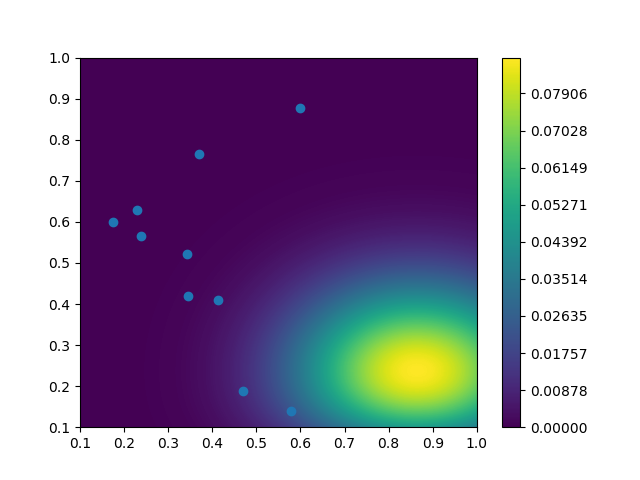

[2.950907523433016,
 1.0210439513025038,
 -10.788239229217524,
 0.706299385152492,
 -17.065943940324104,
 0.11221091351086382]

In [2]:
class Bumps (object):
    
    def __init__(self, Nbumps, Npoints, bounds):

        # Calculate the initial set of coefficients for the bump characteristics
        self.c0 = [0.0]*(Nbumps * 6) 
        for i, bound in enumerate(bounds):
            l, u = bound
            self.c0[i] = random.uniform(l, u);

        # Generate some random points in the domain [0.1,1.0] for both variables
        self.xp = (1-0.1)*(np.random.random((1,Npoints))) + 0.1;
        self.yp = (1-0.1)*(np.random.random((1,Npoints))) + 0.1;
        self.zp = self.f_givenxy(self.c0, self.xp, self.yp);

        checkval = self.objective(self.c0);
        
        assert(abs(checkval) < 1e-16);
        if (abs(checkval) > 1e-16):
            raise ValueError("Did not start out with zero objective function!");
    
    def f_givenxy(self, c, x, y):
        """
        @brief Calculate the functional value for a set of vectors of points
        @brief xb The x coordinate of the center of the bump
         * @brief x The x coordinate of the points to be evaluated
         * @brief y The y coordinate of the points to be evaluated
         */
         """
        s = 0;
        chunksize = 6;
        assert(len(c)%chunksize==0);
        for i in range(0, len(c), chunksize):
            s += np.power(x,c[i+0])*np.power(y,c[i+1])*np.exp(c[i+2]*np.power(x-c[i+3],2) +c[i+4]*np.power(y-c[i+5],2));
        return s;
    
    def objective(self, c):
        return np.sum(np.power(self.f_givenxy(c, self.xp, self.yp) - self.zp, 2))
    
    def plot_surface(self):
        Nx = 100; Ny = 100;
        X,Y = np.meshgrid(np.linspace(0.1,1,Nx), np.linspace(0.1,1,Ny))
        X.reshape(Nx*Ny,1); Y.reshape(Nx*Ny,1);
        Z = self.f_givenxy(self.c0, X, Y).reshape(Nx,Ny);
        
        levels = np.linspace(np.min(Z), np.max(Z), 300);
        plt.contourf(X, Y, Z, levels);
        
        plt.colorbar(); 
        plt.scatter(self.xp, self.yp);
        plt.show();

Nbumps = 1
bounds = []
for bump in range(Nbumps):
    bounds.append((1.0, 4.0)); # ex
    bounds.append((1.0, 4.0)); # ey
    bounds.append((-50.0, -10.0)); # gx
    bounds.append((0.1, 1.0)); # xb
    bounds.append((-50.0, -10.0)); # gy
    bounds.append((0.1, 1.0)); # yb

bumps = Bumps(Nbumps, Nbumps*10, bounds)
bumps.plot_surface()
bumps.c0

In [11]:
D = len(bounds)
CEGO_bounds = [PyCEGO.Bound(b[0],b[1]) for b in bounds]

def CEGO_obj(xvec):
    return bumps.objective([x.as_double() for x in xvec])

layers = PyCEGO.NumberishLayers(CEGO_obj, D, D*50, 1, 3)
layers.set_bounds(CEGO_bounds)
layers.set_builtin_evolver(PyCEGO.BuiltinEvolvers.differential_evolution)

VTR = 1e-15 # value to reach for acceptable optimization
for counter in range(10000):
    layers.do_generation()
    cost, coeffs = layers.get_best()
    if counter % 50 == 0:
        print(layers.print_diagnostics())
    if cost < VTR:
        break

print('CEGO', cost)

i: 0 best: 3.16373e-07 c: 2.950648, 3.829365, -25.647728, 0.450911, -23.844449, 0.356075,  queue: 0
i: 50 best: 7.48318e-08 c: 3.372423, 3.676283, -17.484687, 0.362945, -29.530382, 0.415640,  queue: 0
i: 100 best: 1.17099e-08 c: 2.726355, 3.835050, -20.578295, 0.411122, -38.850651, 0.418566,  queue: 0
i: 150 best: 5.11768e-09 c: 3.327583, 3.054472, -19.718880, 0.374397, -38.887993, 0.431878,  queue: 0
i: 200 best: 2.50624e-09 c: 2.850728, 3.222217, -22.088029, 0.401970, -44.754350, 0.430329,  queue: 0
i: 250 best: 4.03096e-10 c: 3.449846, 2.742353, -20.586151, 0.371421, -40.546903, 0.435988,  queue: 0
i: 300 best: 2.64254e-10 c: 3.623199, 2.382902, -20.473908, 0.356767, -43.762696, 0.447876,  queue: 0
i: 350 best: 6.49496e-11 c: 3.610321, 2.471694, -20.144687, 0.356395, -41.990009, 0.444346,  queue: 0
i: 400 best: 2.13081e-11 c: 3.424940, 2.687126, -20.513017, 0.368153, -41.922925, 0.438912,  queue: 0
i: 450 best: 7.30039e-12 c: 3.439702, 2.685632, -20.465367, 0.367543, -41.846659, 0.4